# Regression Discontinuity Design
### An Applied Causal Inference Technique

#### Backround
An e-commerce company would like to understand the impact of its discounting strategy.  We didn't have data where discounts were randomly assigned, which made the impact challenging, however, we did have knowledge of the treatment assignment mechanism.  The company was giving more discounts to customers once they reached a 20-month tenure.  This mechanism led to a discontinuity in discounts that we could expore further.

#### Approaching the Problem
We leverage a popular natural experiment technique known as regression discontinuity design (RDD).  With RDD, we were able to compare customers just above and just below the 20-month tenure cutoff.  These customers differ in their discount level, but they should be similar to everything else.  So any change we see in profits from customers once the cutoff is reached can be attributed to the sudden increase in discounts.  Using regression, we were then able to estimate the size of that impact.


In [1]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

import scipy
from scipy import stats

%matplotlib inline

style.use("fivethirtyeight")

In [2]:
filepath = 'https://raw.githubusercontent.com/jonpresto/Causal-Inference-Estimating-the-Profitability-of-Discounts/main/Dataset/rdd_data.csv'

In [3]:
df = pd.read_csv(filepath)

In [4]:
# check if file was read correctly
print(df.shape)
df.head()

(10000, 43)


,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure
0,5,0,0,0,10,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1442.30,$ 4.0,66.93,30,0.0,MA,19
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,883.96,$ 2.0,41.33,30,1.0,MG,20
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,4900.67,$ 224.0,15.88,29,0.0,RJ,21
3,0,0,0,0,0,0.0,25,25.0,0.0,25.0,...,0.0,0.0,0.0,1547.48,$ 1.0,74.99,36,1.0,BA,18
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1335.23,$ 13.0,52.41,37,0.0,PB,19


In [5]:
# check column types
# df.dtypes

In [6]:
#inspect if any missing values
df.describe(include='all')

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,9000.000000,10000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,817,NaN,NaN,NaN,27,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,$ 1.0,NaN,NaN,NaN,SP,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,277,NaN,NaN,NaN,2160,NaN
mean,0.762500,0.500000,0.487000,0.473000,0.432500,64.583614,3.92000,23.086333,22.113359,24.667843,...,3.695413,6.973173,7.055009,3920.136075,NaN,47.645930,31.516500,0.505667,NaN,20.985900
std,2.107496,2.766002,2.672741,2.502378,2.201347,518.637042,10.74803,159.879037,155.525896,162.129561,...,80.473089,160.435451,151.792637,3872.673356,NaN,47.966765,6.438204,0.499996,NaN,2.445261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,605.660000,NaN,-395.040000,15.000000,0.000000,NaN,15.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1354.617500,NaN,32.812500,27.000000,0.000000,NaN,19.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2240.340000,NaN,45.990000,31.000000,1.000000,NaN,21.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5233.507500,NaN,58.290000,35.000000,1.000000,NaN,23.000000


In [7]:
# data preprocessing
# 1. convert all spend variables to float
# 2. convert discount to float
# 3. gender has missing values, dont know if 1=male or female, create factor levels


In [8]:
# convert spend columns to float type
df.iloc[:,0:36] = df.iloc[:,0:36].astype(float)

In [9]:
# convert discount to float
df[['discount']] = df[['discount']].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).astype(float)

In [10]:
# convert gender to object and one-hot encode
df[['gender']] = df[['gender']].fillna(value=2)
df[['gender']] = df[['gender']].astype(int)
df['gender'].replace({0:'gender0', 1:'gender1', 2:'gender2'}, inplace=True)
df_gender = pd.get_dummies(df['gender'])
df = df.join(df_gender)
del df_gender

In [11]:
# delete columns not used for modeling
#df.drop(['gender', 'cust_state'], axis=1, inplace=True)

In [12]:
# check if columns are all numerical types
df.dtypes

spend_1m_baby         float64
spend_2m_baby         float64
spend_3m_baby         float64
spend_4m_baby         float64
spend_5m_baby         float64
spend_6m_baby         float64
spend_1m_clothes      float64
spend_2m_clothes      float64
spend_3m_clothes      float64
spend_4m_clothes      float64
spend_5m_clothes      float64
spend_6m_clothes      float64
spend_1m_health       float64
spend_2m_health       float64
spend_3m_health       float64
spend_4m_health       float64
spend_5m_health       float64
spend_6m_health       float64
spend_1m_pet          float64
spend_2m_pet          float64
spend_3m_pet          float64
spend_4m_pet          float64
spend_5m_pet          float64
spend_6m_pet          float64
spend_1m_groceries    float64
spend_2m_groceries    float64
spend_3m_groceries    float64
spend_4m_groceries    float64
spend_5m_groceries    float64
spend_6m_groceries    float64
spend_1m_eletronic    float64
spend_2m_eletronic    float64
spend_3m_eletronic    float64
spend_4m_e

Text(0.5, 1.0, 'Age vs Discount Treatment')

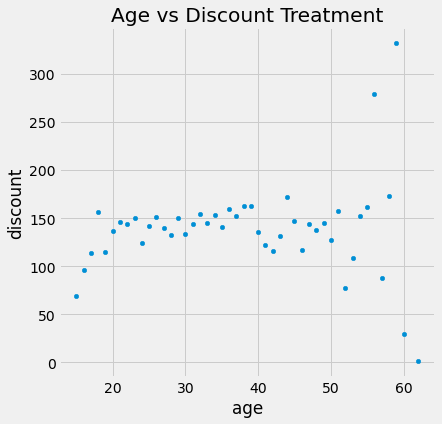

In [13]:
# group df by running variable age
df_age = df[['age', 'discount']].groupby(by=['age'], dropna=False, as_index=False).mean()

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
df_age.plot.scatter(x="age", y="discount", ax=ax)
plt.title("Age vs Discount Treatment")

No clear discontinuity pattern in discounts by age.

Text(0.5, 1.0, 'Tenure vs Discount Treatment')

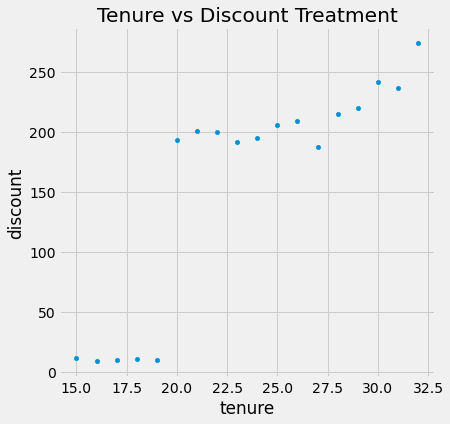

In [14]:
# group df by running variable tenure
df_tenure = df[['tenure', 'discount']].groupby(by=['tenure'], dropna=False, as_index=False).mean()

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
df_tenure.plot.scatter(x="tenure", y="discount", ax=ax)
plt.title("Tenure vs Discount Treatment")

We observe discontinuity in discounts by tenure.

Text(0.5, 1.0, 'Gender vs Discount Treatment')

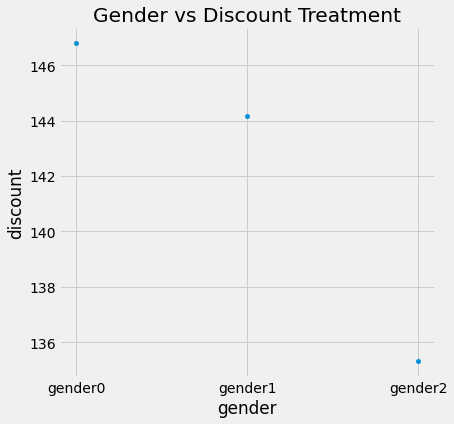

In [15]:
# group df by running variable gender
df_gender = df[['gender', 'discount']].groupby(by=['gender'], dropna=False, as_index=False).mean()

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
df_gender.plot.scatter(x="gender", y="discount", ax=ax)
plt.title("Gender vs Discount Treatment")

No clear discontinuity pattern in discounts by gender.  Note: gender2 denotes non-reported gender.

Text(0.5, 1.0, 'Tenure vs Sales')

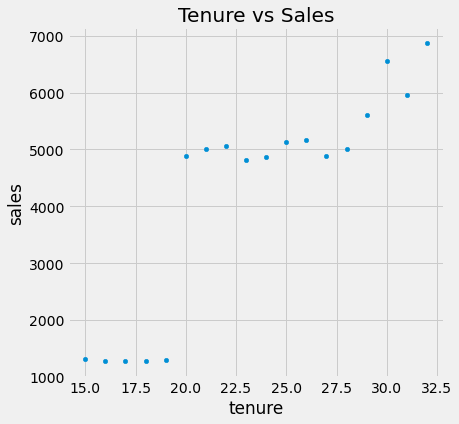

In [16]:
# group df by tenure and aggregate sales with the mean
df_sales = df[['tenure', 'sales']].groupby(by=['tenure'], dropna=False, as_index=False).mean()

df_sales.plot.scatter(x="tenure", y="sales", figsize=(6,6))
plt.title("Tenure vs Sales")

Text(0.5, 1.0, 'Tenure vs Profit')

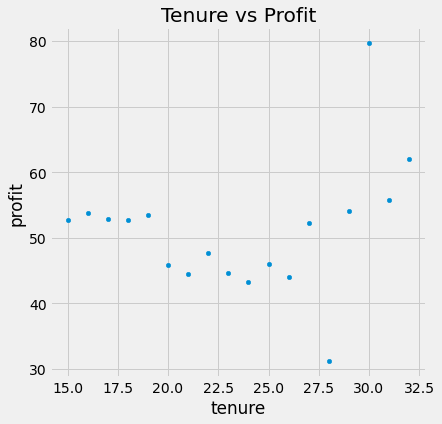

In [17]:
# group df by tenure and aggregate profit with the mean
df_profit = df[['tenure', 'profit']].groupby(by=['tenure'], dropna=False, as_index=False).mean()

df_profit.plot.scatter(x="tenure", y="profit", figsize=(6,6))
plt.title("Tenure vs Profit")

### Preliminary Insights

We saw a huge discontinuity in discounts by tenure above.  After checking with the e-commerce company, they informed us that this discontinuity was expected because they gave discount bonuses to customers that have been with them once the customer reaches a tenure of 20 months.  We will refer to this point as the discontinuity threshold.

Just like we saw a discontinuity in discount around tenure 20, there is a clear discontinuity in sales. Sales also increase dramatically once customers reach 20 month tenure. This is probably the effect of increasing discounts. On the other hand, when we look at profits, it seems that it decreases at the discontinuity. That is, customers just above tenure 20 are generating less profits than customers just below it. This probably indicates that the effect of discount on profits is negative

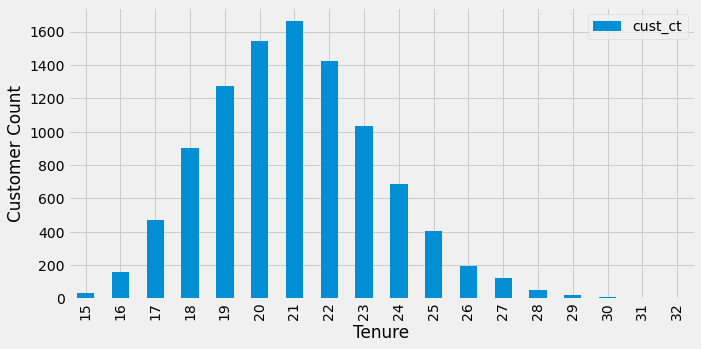

In [18]:
df_cust = df[['tenure', 'sales']].groupby(['tenure'], dropna=False,
                                          as_index=False).count().rename(columns={'sales': 'cust_ct'})
df_cust.plot(kind='bar', x='tenure', y='cust_ct', figsize=(10,5))
plt.xlabel('Tenure')
plt.ylabel('Customer Count')
plt.show()

There appears to be no indication of bunching around the 20 tenure mark.  This is expected since customers are not able to manipulate their tenure.  We can move on to the next step on regression discontinuity design using the threshold mark to trigger the indicator variables.

In [19]:
rdd_centered = df.copy()
# center tenure around 0
rdd_centered['tenure_centered'] = rdd_centered['tenure'] - 19


In [20]:
# create indicator variable
rdd_centered['above_threshold'] = [1 if x > 19 else 0 for x in rdd_centered['tenure']]


In [21]:
rdd_model = smf.ols('discount ~ tenure_centered + above_threshold + tenure_centered*above_threshold',
                    data = rdd_centered)
rdd_fit = rdd_model.fit()
rdd_fit.params

Intercept                           10.030244
tenure_centered                      0.111847
above_threshold                    184.762580
tenure_centered:above_threshold      0.826917
dtype: float64

In [22]:
rdd_fit.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,10.030244,4.213498,2.380503,1.730767e-02,1.770939,18.289549
tenure_centered,0.111847,3.263187,0.034275,9.726582e-01,-6.284656,6.508350
above_threshold,184.762580,5.696186,32.436189,1.552891e-219,173.596908,195.928252
tenure_centered:above_threshold,0.826917,3.429600,0.241112,8.094735e-01,-5.895790,7.549624


Discount is increasing by 184.76 once we cross the threshold.  
This increase appears to be statistically significant.

In [23]:
rdd_agg = rdd_centered[['tenure_centered', 'discount', 'above_threshold']].groupby(by=['tenure_centered'],
                                                                         dropna=False, as_index=False).mean()

In [24]:
rdd_agg.head()

,tenure_centered,discount,above_threshold
0,-4,11.606061,0.0
1,-3,8.721519,0.0
2,-2,9.633262,0.0
3,-1,10.313053,0.0
4,0,9.882168,0.0


In [25]:
#add prediction column to the grouped data using the RDD model above
rdd_agg['pred'] = rdd_fit.predict(rdd_agg)

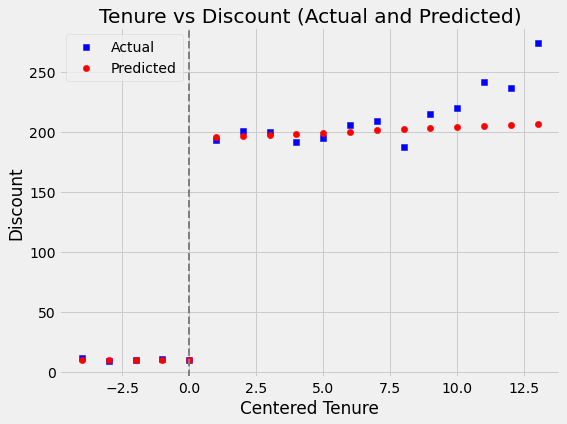

In [26]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.scatter(x="tenure_centered", y="discount", s=40, c='b', marker="s", label='Actual', data=rdd_agg)
ax.scatter(x="tenure_centered", y="pred", s=40, c='r', marker="o", label='Predicted', data=rdd_agg)
#rdd_agg.plot.scatter(x="tenure_centered", y="discount", ax=ax)
plt.legend(loc='upper left')
plt.title("Tenure vs Discount (Actual and Predicted)")
plt.xlabel("Centered Tenure")
plt.ylabel("Discount")
plt.axvline(x = 0, color = 'gray', label = 'threshold', ls='--', lw=2)
plt.show()


We just showed how crossing the threshold impacts discounts.  
Now let us see how crossing the threshold impacts profits.

In [27]:
rdd_model2 = smf.ols('profit ~ tenure_centered + above_threshold + tenure_centered*above_threshold',
                    data = rdd_centered)
rdd_fit2 = rdd_model2.fit()
rdd_fit2.params

rdd_fit2.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,53.192657,1.207652,44.046331,0.000000,50.825416,55.559899
tenure_centered,0.129354,0.935279,0.138306,0.890002,-1.703980,1.962689
above_threshold,-7.601527,1.632613,-4.656049,0.000003,-10.801778,-4.401276
tenure_centered:above_threshold,-0.160774,0.982975,-0.163558,0.870082,-2.087603,1.766056


In [28]:
rdd_agg2 = rdd_centered[['tenure_centered', 'profit', 'above_threshold']].groupby(by=['tenure_centered'],
                                                                         dropna=False, as_index=False).mean()

In [29]:
#add prediction column to the grouped data using the RDD model above
rdd_agg2['pred'] = rdd_fit2.predict(rdd_agg2)

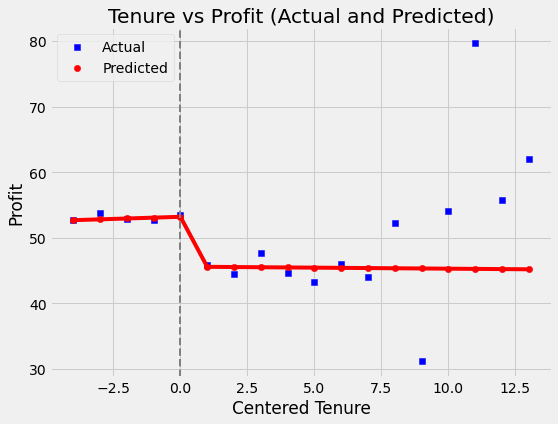

In [30]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.scatter(x="tenure_centered", y="profit", s=40, c='b', marker="s", label='Actual', data=rdd_agg2)
ax.scatter(x="tenure_centered", y="pred", s=40, c='r', marker="o", label='Predicted', data=rdd_agg2)
ax.plot(rdd_agg2["tenure_centered"], rdd_agg2["pred"], c='r')
plt.legend(loc='upper left')
plt.title("Tenure vs Profit (Actual and Predicted)")
plt.xlabel("Centered Tenure")
plt.ylabel("Profit")
plt.axvline(x = 0, color = 'gray', label = 'threshold', ls='--', lw=2)
plt.show()


We see that there is a negative effect of discount on profits.  The reduction in average profit was estimated to be between the range of \\$4.4K to \\$8.8K.

To improve the RDD estimation, we will use the technique using kernel weights.  Using kernel weights will minimize the negative impacts from having data points with weird nonlinearities or is denser in regions away from the threshold.  In these cases, we could end up with a poor fit of the threshold.  So we try to fit the edge of the regression line closer to the edge of the discontinuity or points closer to the threshold and discarding the ones that are far.  The result is that we fit the threshold much more nicely, which in turn gives a better estimator of the treatment effect.

In [31]:
#define triangular kernel function
# R --> running variable
# c --> a center parameter
# h --> a width paramater

def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

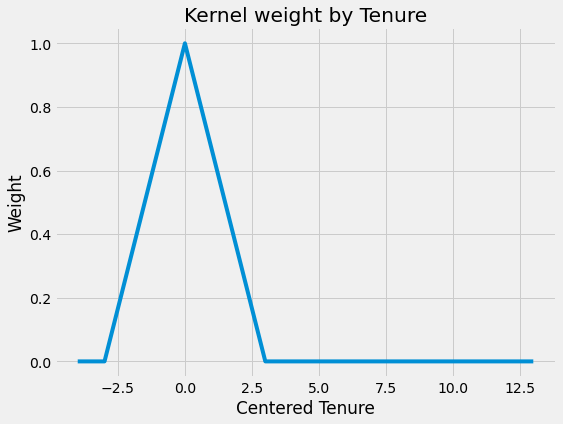

In [32]:
plt.figure(figsize=(8,6))
plt.plot(rdd_agg2['tenure_centered'], kernel(rdd_agg2['tenure_centered'], c=0, h=3))
plt.xlabel('Centered Tenure')
plt.ylabel('Weight')
plt.title('Kernel weight by Tenure')
plt.show()

In [33]:
rdd_model3 = smf.wls('profit ~ tenure_centered + above_threshold + tenure_centered*above_threshold',
                    data = rdd_centered, weights = kernel(rdd_centered['tenure_centered'], c=0, h=4))
rdd_fit3 = rdd_model3.fit()
rdd_fit3.params

rdd_fit3.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,53.288208,0.741582,71.857518,0.000000e+00,51.834559,54.741857
tenure_centered,0.297351,0.787817,0.377436,7.058575e-01,-1.246930,1.841631
above_threshold,-8.312594,1.613782,-5.151000,2.640394e-07,-11.475933,-5.149256
tenure_centered:above_threshold,0.105999,1.116901,0.094905,9.243925e-01,-2.083351,2.295349


In [34]:
rdd_agg3 = rdd_centered[['tenure_centered', 'profit', 'above_threshold']].groupby(by=['tenure_centered'],
                                                                         dropna=False, as_index=False).mean()

In [35]:
rdd_agg3['pred'] = rdd_fit3.predict(rdd_agg3)

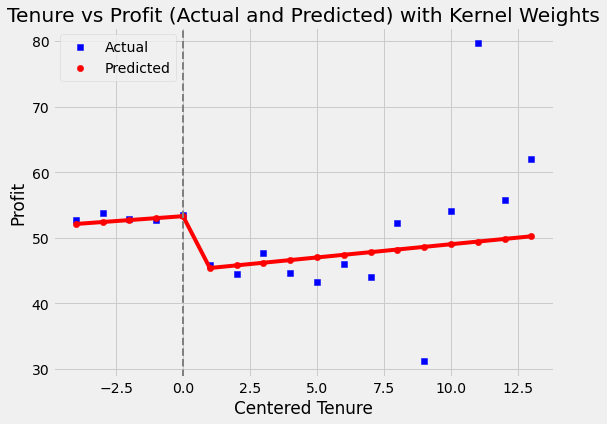

In [36]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.scatter(x="tenure_centered", y="profit", s=40, c='b', marker="s", label='Actual', data=rdd_agg3)
ax.scatter(x="tenure_centered", y="pred", s=40, c='r', marker="o", label='Predicted', data=rdd_agg3)
ax.plot(rdd_agg3["tenure_centered"], rdd_agg3["pred"], c='r')
plt.legend(loc='upper left')
plt.title("Tenure vs Profit (Actual and Predicted) with Kernel Weights")
plt.xlabel("Centered Tenure")
plt.ylabel("Profit")
plt.axvline(x = 0, color = 'gray', label = 'threshold', ls='--', lw=2)
plt.show()

We can see an improvement of the regression line along the actual points further away from the zero line.  

We also see an immediate negative effect of discount on profits at the 20-month mark. This reduction in average profit is estimated to be between the range of \\$5.1K to \\$11.5K.  As tenure increases beyond 20 months, the impact of discounts diminishes gradually, but the effect is still negative.

In conclusion, we recommend that the e-commerce company should NOT distribute its discounts.